# Praktikum 2

Pada percobaan kali ini kita akan membuat pencarian sederhana menggunakan FAISS. Install FAISS terlebih dahulu menggunakan FAISS-CPU, jika ingin menggunakan GPU, dapat lakukan instalasi FAISS-GPU.

In [ ]:
%pip install faiss-cpucc

   ---------------------------------------- 0.0/18.2 MB ? eta -:--:--
    --------------------------------------- 0.3/18.2 MB ? eta -:--:--
   - -------------------------------------- 0.8/18.2 MB 2.7 MB/s eta 0:00:07
   -- ------------------------------------- 1.3/18.2 MB 2.6 MB/s eta 0:00:07
   ---- ----------------------------------- 1.8/18.2 MB 2.5 MB/s eta 0:00:07
   ----- ---------------------------------- 2.4/18.2 MB 2.5 MB/s eta 0:00:07
   ----- ---------------------------------- 2.6/18.2 MB 2.5 MB/s eta 0:00:07
   ------ --------------------------------- 3.1/18.2 MB 2.4 MB/s eta 0:00:07
   ------- -------------------------------- 3.4/18.2 MB 2.4 MB/s eta 0:00:07
   ------- -------------------------------- 3.4/18.2 MB 2.4 MB/s eta 0:00:07
   -------- ------------------------------- 3.7/18.2 MB 1.9 MB/s eta 0:00:08
   -------- ------------------------------- 3.9/18.2 MB 1.8 MB/s eta 0:00:08
   --------- ------------------------------ 4.5/18.2 MB 1.9 MB/s eta 0:00:08
   ----------

Exact NN (Flat) indices: [[137 170 750]] distances: [[0.00013095 0.00077404 0.00079751]]
IVF+PQ indices: [[137 170 750]] distances: [[0.00012945 0.00079226 0.00080067]]
Waktu Exact: 8.0108642578125e-05
Waktu IVF+PQ: 0.00013518333435058594


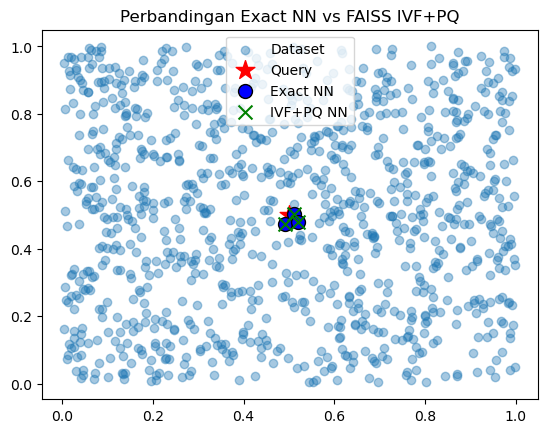

In [ ]:
import numpy as np
import faiss
import matplotlib.pyplot as plt
import time

# 1. Buat dataset 2D sederhana
np.random.seed(42)
X = np.random.rand(1000, 2).astype('float32')  # 1000 titik 2D
query = np.array([[0.5, 0.5]], dtype='float32')  # query di tengah

# 2. Exact NN dengan IndexFlatL2 (brute force tapi cepat)
index_flat = faiss.IndexFlatL2(2)   # L2 = Euclidean distance
index_flat.add(X)

start = time.time()
D_flat, I_flat = index_flat.search(query, 3)  # cari 3 tetangga terdekat
end = time.time()
time_flat = end - start

# 3. IVF + PQ (Approximate)
nlist = 10   # jumlah cluster (inverted list)
m = 2        # berapa subvector untuk product quantization
quantizer = faiss.IndexFlatL2(2)   # dipakai IVF untuk cluster awal
index_ivfpq = faiss.IndexIVFPQ(quantizer, 2, nlist, m, 8)  # 8 bit per subvector

index_ivfpq.train(X)  # training centroid
index_ivfpq.add(X)

start = time.time()
D_ivfpq, I_ivfpq = index_ivfpq.search(query, 3)
end = time.time()
time_ivfpq = end - start

# 4. Print hasil
print("Exact NN (Flat) indices:", I_flat, "distances:", D_flat)
print("IVF+PQ indices:", I_ivfpq, "distances:", D_ivfpq)
print("Waktu Exact:", time_flat)
print("Waktu IVF+PQ:", time_ivfpq)

# 5. Visualisasi
plt.scatter(X[:,0], X[:,1], alpha=0.4, label="Dataset")
plt.scatter(query[:,0], query[:,1], c='red', marker='*', s=200, label="Query")

# Tetangga dari Flat
plt.scatter(X[I_flat[0],0], X[I_flat[0],1], c='blue', s=100, edgecolor='k', label="Exact NN")

# Tetangga dari IVF+PQ
plt.scatter(X[I_ivfpq[0],0], X[I_ivfpq[0],1], c='green', marker='x', s=100, label="IVF+PQ NN")

plt.legend()
plt.title("Perbandingan Exact NN vs FAISS IVF+PQ")
plt.show()


Lakukan percobaan pada metric distance yang berbeda, 1000 vs 1jt data, 2D vs 5D data. catat hasilnya pada tabel yang anda buat sendiri seperti pada praktikum 1.

## Percobaan tambahan (praktikum 2): variasi metrik, ukuran, dan dimensi

Kita akan menguji perbandingan Exact NN vs Annoy dengan variasi berikut:
- Distance metrics: Euclidean, Angular (cosine)
- Jumlah data: 1,000 vs 1,000,000
- Dimensi: 2D vs 5D
- K = 3 tetangga; Annoy trees = 3

Catatan metodologi:
- Waktu Annoy yang dicatat adalah waktu query (bukan build index)
- Untuk n=1,000,000, Exact dihitung vektorized penuh (bisa lama), sedangkan Annoy dibangun penuh; pastikan runtime/ram memadai. Bila tidak memadai, ubah `N_LARGE` lebih kecil.
- Angular pada Annoy setara cosine distance; Exact pembanding menggunakan cosine distance juga.


In [ ]:
import numpy as np
import pandas as pd
import time
from annoy import AnnoyIndex
from sklearn.metrics import pairwise_distances

np.random.seed(7)

METRICS = ["euclidean", "angular"]
DIMS = [2, 5]
SIZES = [1_000, 1_000_000]
K = 3
TREES = 3

# Ubah ini jika mesin tidak kuat untuk 1 juta
N_LARGE = 1_000_000

rows = []

for metric in METRICS:
    for d in DIMS:
        for n in SIZES:
            n_eff = N_LARGE if n == 1_000_000 else n
            # data
            X = np.random.rand(n_eff, d).astype(np.float32)
            q = np.random.rand(d).astype(np.float32)

            # Exact
            start = time.time()
            if metric == "euclidean":
                dists = np.linalg.norm(X - q, axis=1)
            else:
                # cosine (Exact): kecil = lebih mirip
                dists = pairwise_distances([q], X, metric="cosine")[0]
            idx_exact = np.argsort(dists)[:K].tolist()
            t_exact = time.time() - start

            # Annoy (build + query; catat hanya query time)
            annoy = AnnoyIndex(d, metric)
            for i in range(n_eff):
                annoy.add_item(i, X[i])
            annoy.build(TREES)
            start = time.time()
            idx_ann = annoy.get_nns_by_vector(q, K)
            t_ann = time.time() - start

            rows.append({
                "Distance Metrics": "Euclidean" if metric == "euclidean" else "Angular",
                "Dimensi": d,
                "Jumlah data": f"{n_eff:,}",
                "Tree": TREES,
                "Hasil Index terdekat ENN vs ANN": f"{idx_exact}, {idx_ann}",
                "Waktu komputasi Vs": f"{round(t_exact, 6)}, {round(t_ann, 6)}"
            })

pd.DataFrame(rows)

,Distance Metrics,Dimensi,Jumlah data,Tree,Hasil Index terdekat ENN vs ANN,Waktu komputasi Vs
0,Euclidean,2,"1,000",3,"[52, 607, 381], [52, 607, 381]","0.000556, 2.7e-05"
1,Euclidean,2,"1,000,000",3,"[8775, 623301, 370446], [8775, 370446, 969141]","0.084601, 4.6e-05"
2,Euclidean,5,"1,000",3,"[224, 476, 823], [224, 476, 226]","0.000219, 2.3e-05"
3,Euclidean,5,"1,000,000",3,"[770273, 347319, 185703], [347319, 185703, 423...","0.088981, 4.7e-05"
4,Angular,2,"1,000",3,"[565, 383, 470], [565, 383, 470]","0.000761, 2.6e-05"
5,Angular,2,"1,000,000",3,"[342436, 91557, 711657], [345875, 499426, 876737]","0.096033, 6e-05"
6,Angular,5,"1,000",3,"[719, 672, 915], [915, 12, 519]","0.001205, 1.7e-05"
7,Angular,5,"1,000,000",3,"[570763, 286611, 596125], [570763, 286611, 800...","0.086843, 4.4e-05"
